In [55]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi, gaussian, threshold_otsu, threshold_yen, threshold_multiotsu
from skimage.color import rgb2gray
import skimage.morphology as mp
from skimage import exposure
import math

In [2]:
image_name = 'healthy/01_h.jpg'
image_fov = 'healthy_fovmask/01_h_mask.tif'

In [51]:
def detect_vessels(img, image_fov):
    # Normalizacja histogramu kolorów
    colorimage_b = img[:,:,0]
    colorimage_g = cv2.equalizeHist(img[:,:,1])
    colorimage_r = img[:,:,2]
    img = np.stack((colorimage_b,colorimage_g,colorimage_r), axis=2)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Usuwanie szumów przy pomocy gaussiana
    img = gaussian(img, sigma=(10), channel_axis=-1)

    # Zmiana na skalę szarości
    img = rgb2gray(img)
    
    # Filtra frangi
    img = frangi(img)

    # Morfologiczna dylatacja (rozszerzenie) i erozja (skurczenie)
    img = mp.dilation(img, mp.disk(4))
    img = mp.erosion(img, mp.disk(4))
    
    # Progowanie Otsu
    thresh = threshold_otsu(img)
    img = img > thresh * 0.1
    
    # Otwieranie fov, iterujemy po pliku
    for x in range(img.shape[0]):
                for y in range(img.shape[1]):
                    if image_fov[x][y] == 0:
                        img[x][y] = 0
                        
    return img

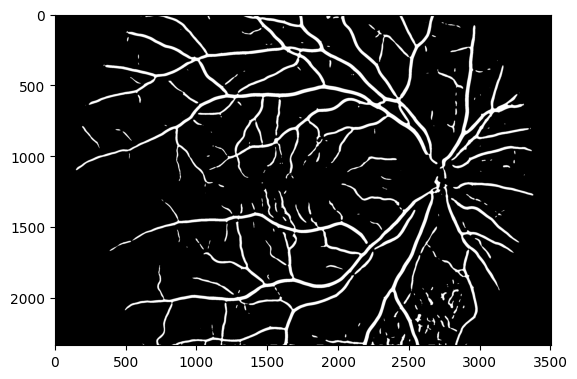

In [52]:
image =  cv2.imread(image_name)
fov =  cv2.imread(image_fov, cv2.IMREAD_GRAYSCALE)
img = detect_vessels(image, fov)
plt.imshow(img,cmap='gray')

In [53]:
image_manual = 'healthy_manual/01_h.tif'

In [57]:
def conf_matrix_for_image(image, manual):
    h, w = manual.shape
    tp, fp, fn, tn = 0, 0, 0, 0

    result = np.zeros(shape=(h,w,3))
    
    for i in range(h):
        for j in range(w):
            if image[i][j] == 1 and manual[i][j] == 255:
                tp += 1
                result[i][j][1] = 1
            if image[i][j] == 1 and manual[i][j] == 0:
                fp += 1
                result[i][j][0] = 1
            if image[i][j] == 0 and manual[i][j] == 255:
                fn += 1
                result[i][j][2] = 1
            if image[i][j] == 0 and manual[i][j] == 0:
                tn += 1

    accuracy = (tp + tn) / (tn + fp + fn + tp) * 100
    sensivity = tp / (tp + fn + 1) * 100
    specifity = tn / (fp + tn + 1) * 100
    geometric_mean = math.sqrt((sensivity * specifity))
    return (accuracy, sensivity, specifity, geometric_mean, result)

manual = cv2.imread(image_manual, cv2.IMREAD_GRAYSCALE)
acc,sens,spec,geo_mean, results_img = conf_matrix_for_image(img, manual)

In [58]:
image = cv2.imread('healthy/0' + str(1) + '_h.jpg')
fov_image = cv2.imread('healthy_fovmask/0' + str(1) + '_h_mask.tif',cv2.IMREAD_GRAYSCALE)
manual_image = cv2.imread('healthy_manual/0' + str(1) + '_h.tif', cv2.IMREAD_GRAYSCALE)

predicted_image = detect_vessels(image,fov_image)
acc,sens,spec,geo_mean, results_img = conf_matrix_for_image(predicted_image, manual_image)

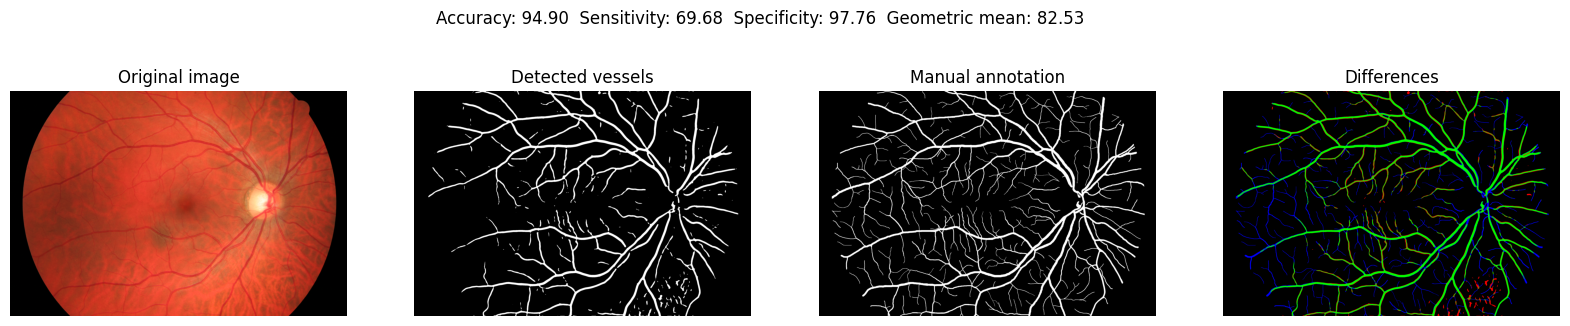

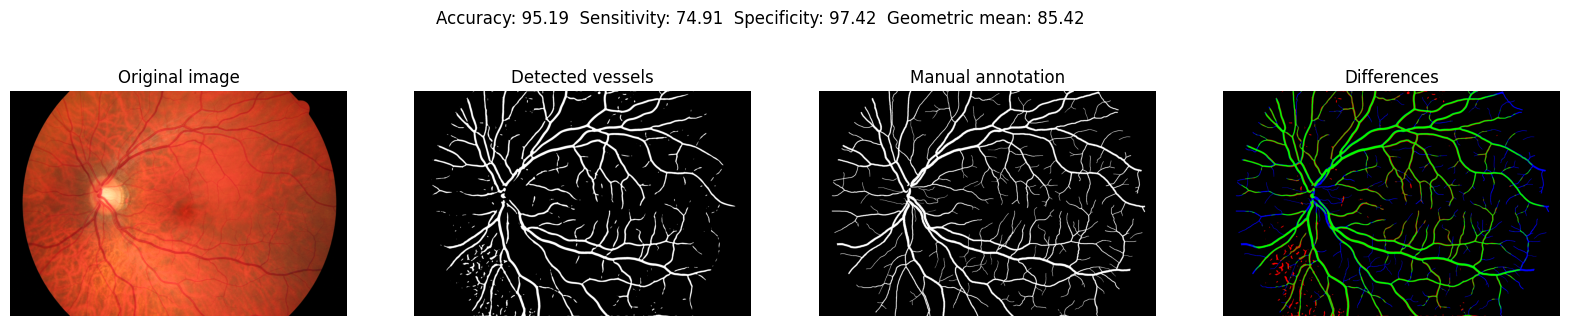

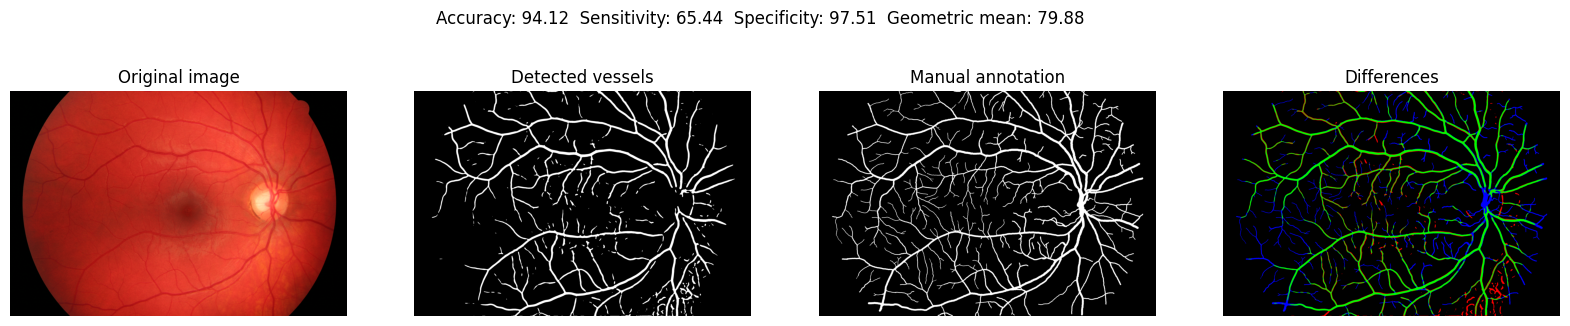

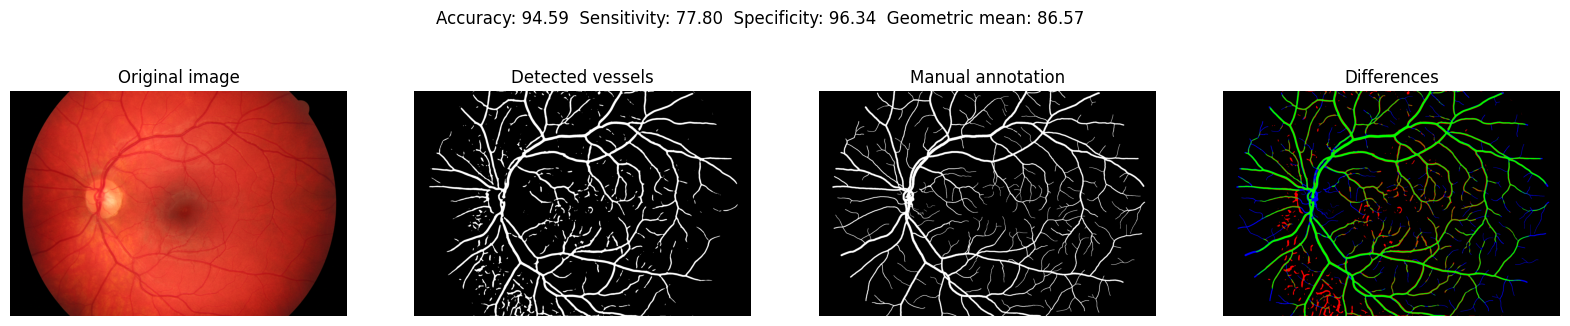

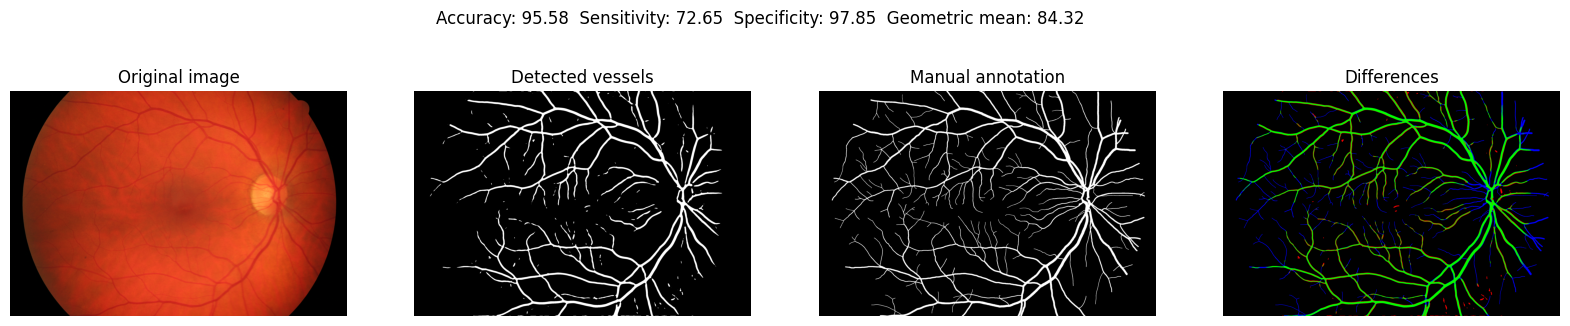

In [59]:
for x in range(1,6):
    fig, axes = plt.subplots(figsize=(20,4),nrows=1, ncols=4)
    
    image = cv2.imread('healthy/0' + str(x) + '_h.jpg')
    fov_image = cv2.imread('healthy_fovmask/0' + str(x) + '_h_mask.tif',cv2.IMREAD_GRAYSCALE)
    manual_image = cv2.imread('healthy_manual/0' + str(x) + '_h.tif', cv2.IMREAD_GRAYSCALE)
    
    predicted_image = detect_vessels(image,fov_image)
    acc,sens,spec,geo_mean, results_img = conf_matrix_for_image(predicted_image, manual_image)

    fig.suptitle(f"Accuracy: {acc:.2f}  Sensitivity: {sens:.2f}  Specificity: {spec:.2f}  Geometric mean: {geo_mean:.2f}")
    
    axes[0].set_title("Original image")
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].axis('off')
    
    axes[1].set_title("Detected vessels")
    axes[1].imshow(predicted_image, cmap='gray')
    axes[1].axis('off')
    
    axes[2].set_title("Manual annotation")
    axes[2].imshow(manual_image, cmap='gray')
    axes[2].axis('off')
    
    axes[3].set_title("Differences")
    axes[3].imshow(results_img, cmap='gray')
    axes[3].axis('off')

    plt.show()